# Liputan6 — Dataset Analysis for Text Summarization (Colab)




# Daftar Isi

- [Langkah 1 — Persiapan & Mount Google Drive](#step1)
- [Langkah 2 — Memuat Dataset (CSV)](#step2)
- [Langkah 3 — Gambaran Umum Kolom (Profil Data)](#step3)
- [Langkah 4 — Nilai Hilang (Missing Values) & Visualisasi](#step4)
- [Langkah 5 — Distribusi Panjang Teks (Artikel & Ringkasan)](#step5)
- [Langkah 6 — Jumlah Kalimat per Artikel (Perkiraan)](#step6)
- [Langkah 7 — Contoh Artikel Terpendek & Terpanjang](#step7)
- [Langkah 8 — Frekuensi Kata Umum (Most Common Words)](#step8)
- [Langkah 9 — Analisis Stopwords dalam Artikel](#step9)


## Langkah 1 — Persiapan & Mount Google Drive

In [1]:

import pandas as pd, numpy as np
import os, math
from pathlib import Path
import matplotlib.pyplot as plt

DATA_PATH = "liputan6_train.csv"
OUTPUT_DIR = Path("./output/")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print('DATA_PATH:', DATA_PATH)
print('OUTPUT_DIR:', OUTPUT_DIR)


DATA_PATH: liputan6_train.csv
OUTPUT_DIR: output


<a id="step2"></a>

## Langkah 2 — Memuat Dataset (CSV)

In [2]:
# Load CSV (use low_memory=False to avoid dtype guessing warnings)
# Try different delimiters if ParserError occurs. Common ones are ',' (default) or ';'
try:
    df = pd.read_csv(DATA_PATH, low_memory=False)
except pd.errors.ParserError as e:
    print(f"ParserError with default delimiter: {e}")
    print("Trying with semicolon delimiter ';'")
    try:
        df = pd.read_csv(DATA_PATH, low_memory=False, sep=';')
    except Exception as e_semi:
        print(f"Error with semicolon delimiter: {e_semi}")
        print("Could not load the dataset with common delimiters. Please check the file format.")
        df = None # Ensure df is None if loading fails

if df is not None:
    print('Rows:', len(df), '| Cols:', len(df.columns))
    display(df.head(3))

Rows: 193883 | Cols: 5


,id,url,article,summary,extractive_summary
0,100000,https://www.liputan6.com/news/read/100000/yudh...,"Liputan6 . com , Jakarta : Presiden Susilo Bam...","Menurut Presiden Susilo Bambang Yudhoyono , ke...","[0, 1]"
1,100002,https://www.liputan6.com/news/read/100002/jepa...,"Liputan6 . com , Jakarta : Perdana Menteri Jep...",Pada masa silam Jepang terlalu ambisius untuk ...,"[2, 3]"
2,100003,https://www.liputan6.com/news/read/100003/pulu...,"Liputan6 . com , Kutai : Banjir dengan ketingg...",Puluhan hektare areal persawahan yang sebagian...,"[1, 5]"


In [3]:
# Tentukan kolom artikel dan ringkasan
# Sesuaikan dengan nama kolom di CSV Anda
if df is not None:
    # Coba deteksi kolom secara otomatis
    possible_article_cols = ['article', 'clean_article', 'clean_article_text', 'text', 'content']
    possible_summary_cols = ['summary', 'clean_summary', 'clean_summary_text', 'ringkasan']
    
    article_col = None
    summary_col = None
    
    for col in possible_article_cols:
        if col in df.columns:
            article_col = col
            break
    
    for col in possible_summary_cols:
        if col in df.columns:
            summary_col = col
            break
    
    print(f"Article column: {article_col}")
    print(f"Summary column: {summary_col}")
else:
    article_col = None
    summary_col = None

Article column: article
Summary column: summary


<a id="step3"></a>

## Langkah 3 — Gambaran Umum Kolom (Profil Data)

In [4]:

print('Columns:', list(df.columns))
display(df.describe(include='all').transpose().fillna(''))


Columns: ['id', 'url', 'article', 'summary', 'extractive_summary']


C:\Users\naufa\AppData\Local\Temp\ipykernel_33292\4048701477.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  display(df.describe(include='all').transpose().fillna(''))


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,193883.0,,,,168003.947381,78141.732151,26408.0,103116.5,171715.0,233933.5,299999.0
url,193883.0,193883,https://www.liputan6.com/news/read/100000/yudh...,1,,,,,,,
article,193883.0,193012,"Liputan6 . com , Jakarta : Di hari perdagangan...",3,,,,,,,
summary,193883.0,192775,"Jumat ( 7/9 ) , genap tiga tahun kematian akti...",4,,,,,,,
extractive_summary,193883.0,8471,"[0, 1]",29927,,,,,,,


<a id="step4"></a>

## Langkah 4 — Nilai Hilang (Missing Values) & Visualisasi

,null_fraction
id,0.0
url,0.0
article,0.0
summary,0.0
extractive_summary,0.0


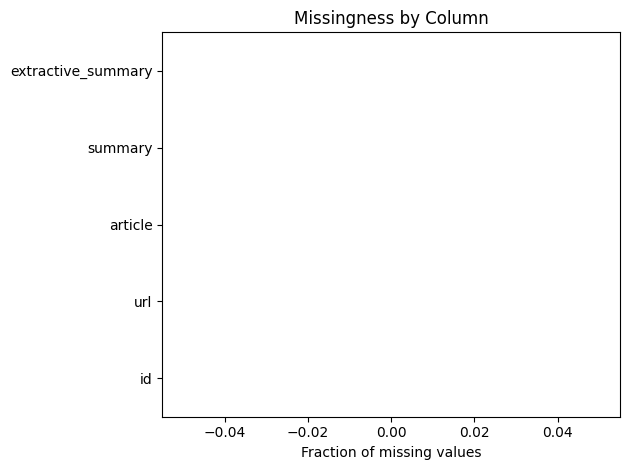

In [5]:

null_frac = df.isna().mean().sort_values(ascending=False)
display(null_frac.to_frame('null_fraction'))

# Plot null fraction
plt.figure()
null_frac.plot(kind='barh')
plt.xlabel('Fraction of missing values')
plt.title('Missingness by Column')
plt.tight_layout()
plt.show()


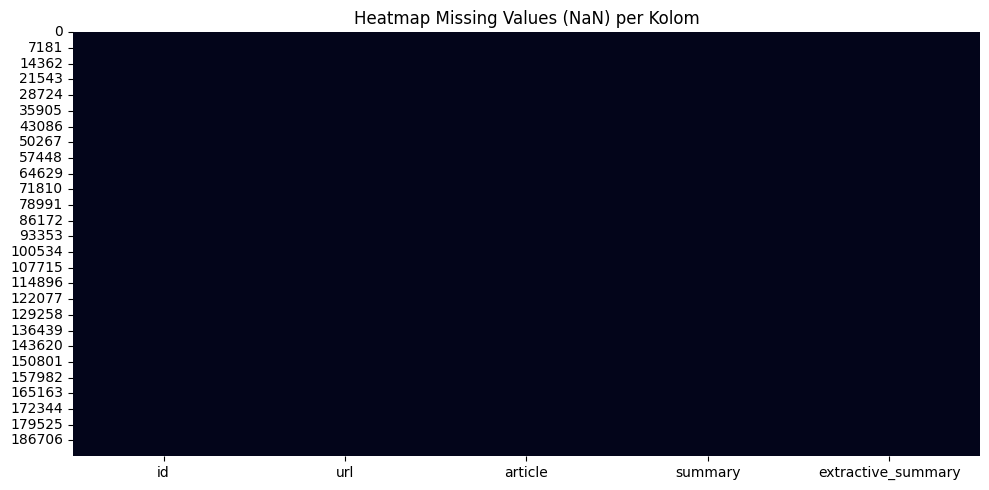

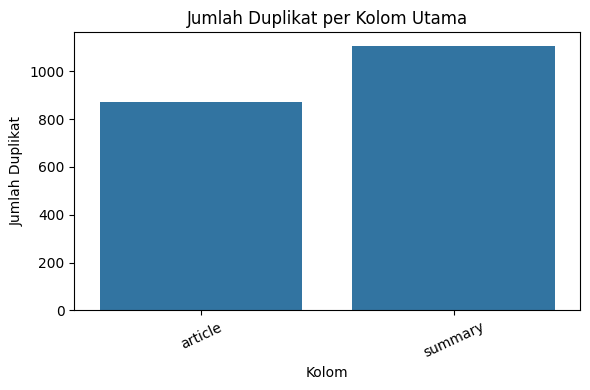

Jumlah duplikat artikel  : 871
Jumlah duplikat ringkasan: 1108


In [6]:
# ============================================================
# 🔍 Visualisasi Lanjutan: Missing Values & Duplikasi
# ============================================================
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap missing values
plt.figure(figsize=(10, 5))
sns.heatmap(df.isna(), cbar=False)
plt.title("Heatmap Missing Values (NaN) per Kolom")
plt.tight_layout()
plt.show()

# Jumlah duplikat berdasarkan kolom utama (gunakan kolom yang terdeteksi)
if article_col and article_col in df.columns:
    dup_article = df.duplicated(subset=[article_col]).sum()
else:
    dup_article = 0

if summary_col and summary_col in df.columns:
    dup_summary = df.duplicated(subset=[summary_col]).sum()
else:
    dup_summary = 0

# Buat DataFrame untuk visualisasi
dup_df = pd.DataFrame({
    'Kolom': [article_col or 'article', summary_col or 'summary'],
    'Jumlah Duplikat': [dup_article, dup_summary]
})

plt.figure(figsize=(6, 4))
sns.barplot(data=dup_df, x='Kolom', y='Jumlah Duplikat')
plt.title("Jumlah Duplikat per Kolom Utama")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

print("Jumlah duplikat artikel  :", dup_article)
print("Jumlah duplikat ringkasan:", dup_summary)

<a id="step5"></a>

<a id="step6"></a>

## Langkah 5 — Distribusi Panjang Teks (Artikel & Ringkasan)

Article length (words): mean/median/p90/max = 234.07 197.0 391.0 7379
Summary length (words): mean/median/p90/max = 30.99 30.0 39.0 102


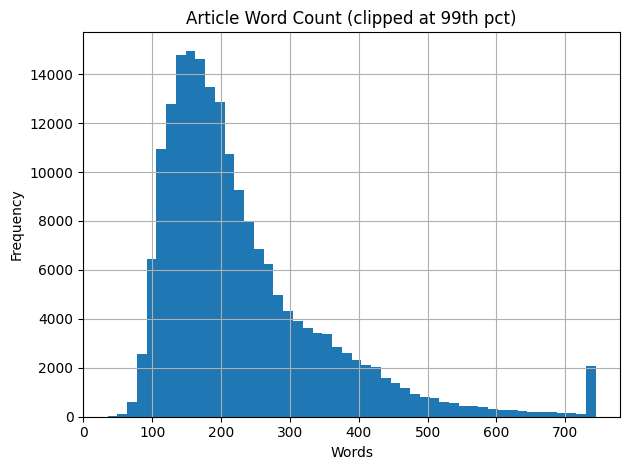

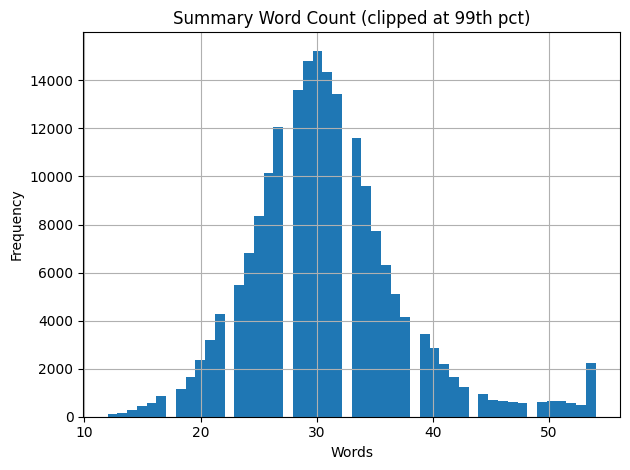

In [ ]:

def count_words(s):
    if pd.isna(s): return 0
    return len(str(s).split())

if article_col and summary_col:
    art_len = df[article_col].apply(count_words)
    sum_len = df[summary_col].apply(count_words)

    print('Article length (words): mean/median/p90/max =',
          round(art_len.mean(),2), np.median(art_len), np.percentile(art_len,90), art_len.max())

    print('Summary length (words): mean/median/p90/max =',
          round(sum_len.mean(),2), np.median(sum_len), np.percentile(sum_len,90), sum_len.max())

    # Histograms
    plt.figure()
    art_len.clip(upper=np.percentile(art_len, 99)).hist(bins=50)
    plt.title('Article Word Count (clipped at 99th pct)')
    plt.xlabel('Words'); plt.ylabel('Frequency')
    plt.tight_layout(); plt.show()

    plt.figure()
    sum_len.clip(upper=np.percentile(sum_len, 99)).hist(bins=50)
    plt.title('Summary Word Count (clipped at 99th pct)')
    plt.xlabel('Words'); plt.ylabel('Frequency')
    plt.tight_layout(); plt.show()
else:
    print("Skip length distribution: no suitable article/summary column.")


<a id="step8"></a>

## Langkah 6 — Jumlah Kalimat per Artikel (Perkiraan)

Sentence count — mean/median/p90/max: 15.22 13.0 24.0 505


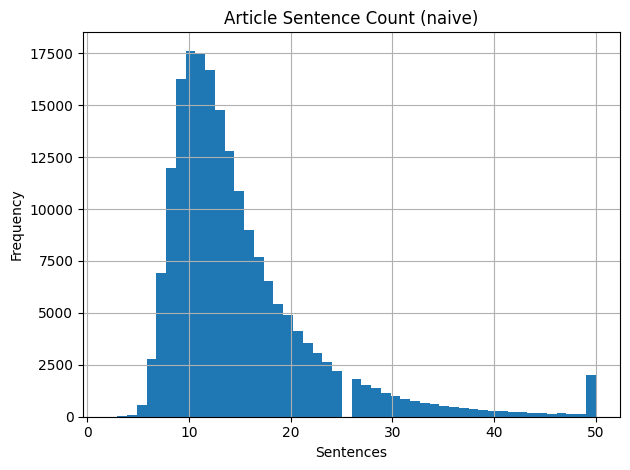

In [ ]:

import re

def count_sentences(text):
    if pd.isna(text): return 0
    # naive split by punctuation . ! ? ; keeping it simple to avoid extra deps
    parts = re.split(r'[.!?;]+', str(text))
    # drop empties
    return len([p for p in parts if p.strip()!=''])

if article_col:
    sent_counts = df[article_col].apply(count_sentences)
    print('Sentence count — mean/median/p90/max:',
          round(sent_counts.mean(),2), np.median(sent_counts), np.percentile(sent_counts,90), sent_counts.max())

    plt.figure()
    sent_counts.clip(upper=np.percentile(sent_counts, 99)).hist(bins=50)
    plt.title('Article Sentence Count (naive)')
    plt.xlabel('Sentences'); plt.ylabel('Frequency')
    plt.tight_layout(); plt.show()


<a id="step9"></a>

## Langkah 7 — Contoh Artikel Terpendek & Terpanjang

In [ ]:

if article_col and summary_col:
    # Show a few examples by length
    art_len = df[article_col].apply(lambda x: len(str(x).split()))
    idx_short = art_len.nsmallest(3).index
    idx_long  = art_len.nlargest(3).index

    print("\n=== Short Articles ===")
    display(df.loc[idx_short, [article_col, summary_col]].head(3))

    print("\n=== Long Articles ===")
    display(df.loc[idx_long, [article_col, summary_col]].head(3))



=== Short Articles ===


,article,summary
79703,Setelah tak terkalahkan dalam empat laga awal ...,Setelah tak terkalahkan dalam empat laga awal ...
73264,Keinginan Alan Curbishley untuk memboyong stri...,Keinginan Alan Curbishley untuk memboyong stri...
55156,"Memasuki musim kemarau , Warga Gunungpati , Se...","Memasuki musim kemarau , warga Gunungpati , Se..."



=== Long Articles ===


,article,summary
111871,"Liputan6 . com , Jakarta : Tim 8 yang dibentuk...",Tim 8 yang dibentuk presiden merekomendasikan ...
23208,"Karikatur Nabi Muhammad SAW Liputan6 . com , D...","Awal 2006 , dunia dikejutkan dengan munculnya ..."
181120,"Liputan6 . com , Jakarta : Diam itu emas . Per...",Putri sulung Presiden Pertama RI Soekarno itu ...


## Langkah 8 — Frekuensi Kata Umum (Most Common Words)
Analisis kata yang paling sering muncul pada kolom `clean_article_text`.


20 Kata Paling Umum (setelah menghapus stopwords):
liputan         209995
com             172111
jakarta         165737
tak             145309
tersebut        129534
warga           125640
tahun           95868
menjadi         94230
rumah           94024
baca            91720
hingga          83630
polisi          83049
satu            81798
indonesia       78025
sejumlah        77396
lebih           74964
tim             72716
korban          72409
pemerintah      70105
hari            69397


,Word,Frequency
0,liputan,209995
1,com,172111
2,jakarta,165737
3,tak,145309
4,tersebut,129534
5,warga,125640
6,tahun,95868
7,menjadi,94230
8,rumah,94024
9,baca,91720


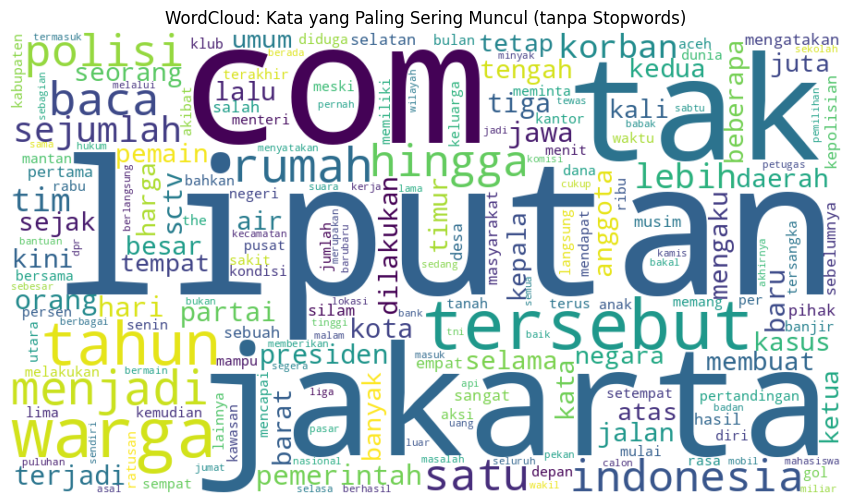

In [ ]:
# ============================================================
# Langkah 8 — Frekuensi Kata Umum (Most Common Words)
# (dengan penghapusan stopwords Bahasa Indonesia)
# ============================================================

# !pip install -q wordcloud Sastrawi # Already installed earlier

import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Gabungkan semua teks artikel dari kolom 'article'
# Convert to string and handle potential NaNs
text_data = " ".join(df['article'].dropna().astype(str)).lower()

# Hapus karakter non-alfabetik dan angka, tapi biarkan spasi
text_data = re.sub(r'[^a-zA-Z\s]', '', text_data)

# Tokenisasi sederhana berdasarkan spasi
tokens = text_data.split()

# Siapkan daftar stopwords Bahasa Indonesia
factory = StopWordRemoverFactory()
stopwords = set(factory.get_stop_words())

# Filter stopwords dan kata pendek (panjang <= 2)
filtered_tokens = [t for t in tokens if t not in stopwords and len(t) > 2]

# Hitung frekuensi kata dari token yang sudah difilter
counter = Counter(filtered_tokens)
common_words = counter.most_common(20)

# Tampilkan 20 kata paling umum
print("20 Kata Paling Umum (setelah menghapus stopwords):")
for word, freq in common_words:
    print(f"{word:<15} {freq}")

# Konversi ke DataFrame untuk tampilan tabel
common_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
display(common_df)

# Buat WordCloud dari frekuensi kata yang sudah difilter
wordcloud = WordCloud(
    width=900, height=500,
    background_color='white',
    max_words=200,
    colormap='viridis' # Use a colormap
).generate_from_frequencies(counter)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud: Kata yang Paling Sering Muncul (tanpa Stopwords)")
plt.show()

## Langkah 9 — Analisis Stopwords dalam Artikel

20 Stopword Paling Sering Muncul dalam Artikel:
di              880970
yang            855936
dan             637067
ini             404784
itu             325920
dengan          303716
dari            303293
untuk           265706
dalam           218837
ke              193063
akan            186618
tidak           183986
juga            178893
mereka          164640
pada            134099
karena          123189
saat            113463
para            108576
masih           102437
dua             99451


,Stopword,Frequency
0,di,880970
1,yang,855936
2,dan,637067
3,ini,404784
4,itu,325920
5,dengan,303716
6,dari,303293
7,untuk,265706
8,dalam,218837
9,ke,193063


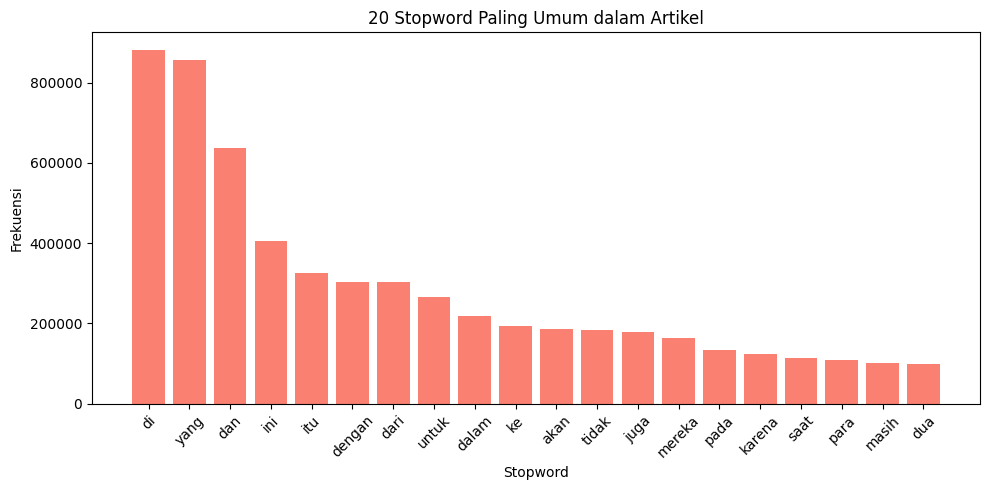

In [ ]:
# ============================================================
# Langkah 9 — Analisis Stopwords dalam Artikel
# ============================================================

import matplotlib.pyplot as plt
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from collections import Counter
import pandas as pd
import re

# Gabungkan semua teks artikel
# Convert to string and handle potential NaNs
text_data = " ".join(df['article'].dropna().astype(str)).lower()

# Hapus karakter non-alfabetik dan angka, tapi biarkan spasi
text_data = re.sub(r'[^a-zA-Z\s]', ' ', text_data)
tokens = text_data.split()

# Siapkan stopword list Bahasa Indonesia
factory = StopWordRemoverFactory()
stopwords = set(factory.get_stop_words())

# Ambil hanya token yang merupakan stopwords
stopword_tokens = [t for t in tokens if t in stopwords]

# Hitung frekuensi stopword
stopword_counter = Counter(stopword_tokens)
common_stopwords = stopword_counter.most_common(20)

# Tampilkan 20 stopword paling umum
print("20 Stopword Paling Sering Muncul dalam Artikel:")
for word, freq in common_stopwords:
    print(f"{word:<15} {freq}")

# Tampilkan dalam bentuk tabel
stop_df = pd.DataFrame(common_stopwords, columns=['Stopword', 'Frequency'])
display(stop_df)

# Visualisasi dengan bar chart
plt.figure(figsize=(10,5))
plt.bar(stop_df['Stopword'], stop_df['Frequency'], color='salmon')
plt.title("20 Stopword Paling Umum dalam Artikel")
plt.xlabel("Stopword")
plt.ylabel("Frekuensi")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()